In [1]:
include("../src/GeneticDemographicModel.jl")
include("../src/DomesticationModel.jl")
include("../src/DemographicParameters.jl")
include("../src/DomesticationParameters.jl")
include("../src/FecundityAgeRelationships.jl")

Main.FecundityAgeRelationships

In [2]:
Sa = DemographicParameters.Smyth_2016_survival
Fa = DemographicParameters.Smyth_16_F_vec
Wa = DemographicParameters.Smyth_16_WAR.(1:(length(Fa)+1))
R0 = 5.0
Rstar = 100.0
r = 0.0
Sd = (X,b) -> GeneticDemographicModel.BevertonHolt(X,b)
Vr = 0.5
# Scenario 1
targets = (S_F = 0.1, S_E = 0.01, S_J = 1.0, S_C = 1.0, rLRS = 0.85, 
           l50 = 40.0, theta = 10.0)
p_fixed = (a_r = 1.0,decreasing_selection = false,b_sa = 0.0,L_0 = 5.0,
            L_infty = 500,k = 0.05,b_Linfty=10.0,h2_lr=0.75, Vr = 0.5)
pars, natural_selection = DomesticationParameters.solve_parameters(targets,p_fixed)

s1 = 0.25*pars.s
s2 = 0.5*pars.s
s3 = 0.25*pars.s
rFaplastic = 0.85

popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
popH = DomesticationModel.init(Sa,Fa,pars)
print("selection strength ", pars.s)

selection strength 0.24653458883755608

In [3]:
pars

(a_r = 1.0, decreasing_selection = false, b_sa = 0.0, L_0 = 5.0, L_infty = 500, k = 0.05, b_Linfty = 10.0, h2_lr = 0.75, Vr = 0.5, s = 0.24653458883755608, s_F = 0.047540841996851664, theta = 9.999652261408087, s_E = 0.1087390314925762, s_J = 1.1982631797364047e-6, l50 = 40.00025299719812, s_l = -5.850363769073782)

In [4]:
using DataFrames, Plots
function init_df(t_init, t_hatchery, t_recovery)
    data = DataFrame()
    data.time = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.Recruitment = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.Fitness = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.mean = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.Fitness_H = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.mean_H = 1:1.0:(t_init+t_hatchery+t_recovery)
    data.variance = 1:1.0:(t_init+t_hatchery+t_recovery)
    return data
end 

function statistics!(data,popW,popH,t)
    
    # calcualte statistics 
    Nt = popW.abundanceN[1]
    gradient = popW.gradient1.*popW.gradient2.*popW.gradient3
    Wt = sum(popW.traitN[:,1].*gradient)
    WHt = sum(popH.trait[:,1].*gradient)
    gbart = sum(popW.traitN[:,1].*popW.grid)
    gbarHt = sum(popH.trait[:,1].*popH.grid)
    Vt = sum(popW.traitN[:,1].*(popW.grid.-gbart).^2)
    
    data.time[t] = t
    data.Recruitment[t] = Nt
    data.Fitness[t] = Wt
    data.Fitness_H[t] = WHt
    data.mean[t] = gbart
    data.mean_H[t] = gbarHt
    data.variance[t] = Vt
    
    return Nt, Wt, gbart, Vt
end


function simulation(popW, popH, rH, t_init, t_hatchery, t_recovery)
    
    data = init_df(t_init, t_hatchery, t_recovery)

    for t in 1:t_init
        GeneticDemographicModel.time_step!(popW, popH.trait[:,1], 0.0)
        statistics!(data,popW,popH,t)
    end 
    
    for t in (t_init+1):(t_init+t_hatchery)
        GeneticDemographicModel.time_step!(popW, popH.trait[:,1], rH)
        DomesticationModel.time_step!(popH)
        statistics!(data,popW,popH,t)
    end 
    
    for t in (t_init+t_hatchery+1):(t_init+t_hatchery+t_recovery)
        GeneticDemographicModel.time_step!(popW, popH.trait[:,1], 0.0)
        statistics!(data,popW,popH,t)
    end 
    
    GeneticDemographicModel.rest!(popW)
    DomesticationModel.rest!(popH)
    
    return data
end


function plot_simulation(data,t_init, t_hatchery; label = "")
    Tstart = t_init
    Tend = t_init + t_hatchery
    p1 = Plots.plot(data.time, data.Fitness./data.Fitness[1], color = "black",label=label,ylabel = "Fitness",linewidth=1.5)
    Plots.vspan!(p1,[Tstart,Tend], alpha = 0.5,label="", xlabel="Time (years)",
                xguidefontsize=13,yguidefontsize=13,xtickfontsize=10,ytickfontsize=10)
    p2 = Plots.plot(data.time, data.Recruitment./data.Recruitment[1], color = "black",label="",ylabel = "Recruitment",linewidth=1.5)
    Plots.vspan!(p2,[Tstart,Tend], alpha = 0.5,label="", xlabel="Time (years)",
                xguidefontsize=13,yguidefontsize=13,xtickfontsize=10,ytickfontsize=10)
    p3 = Plots.plot(data.time, data.mean, color = "black",label="",ylabel = "Mean genotype",linewidth=1.5)
    Plots.vspan!(p3,[Tstart,Tend], alpha = 0.5,label="", xlabel="Time (years)",
                xguidefontsize=13,yguidefontsize=13,xtickfontsize=10,ytickfontsize=10)
    p4 = Plots.plot(data.time, data.variance, color = "black",label="",ylabel = "Genotype var.",linewidth=1.5)
    Plots.vspan!(p4,[Tstart,Tend], alpha = 0.5,label="", xlabel="Time (years)",
                xguidefontsize=13,yguidefontsize=13,xtickfontsize=10,ytickfontsize=10)
    
    return p1,p2,p3,p4

end 

plot_simulation (generic function with 1 method)

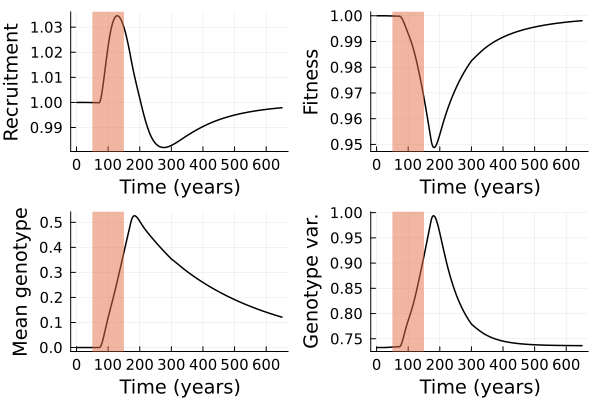

In [5]:
rH = 50
t_init = 50
t_hatchery = 100
t_recovery = 500
popW_ = GeneticDemographicModel.init(Sa,Fa,Wa,R0+0.01*R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
data = simulation(popW_, popH, rH, t_init, t_hatchery, t_recovery)
p1,p2,p3,p4=plot_simulation(data,t_init, t_hatchery; label = "")
plot(p2,p1,p3,p4)

In [47]:
function minimum_values(data)
    W = data.Fitness./data.Fitness[1]
    Wmin = W[argmin(W)]
    N = data.Recruitment
    Nmin = N[argmin(N)]
    g = data.mean
    gmin = g[argmax(g)]
    return Wmin, Nmin,gmin 
end 


function heatmap_data(popW,popH,rH_range,t_hatchery_range; N = 10,t_init=10,t_recovery=200) 
    R = zeros(N,N)
    W = zeros(N,N)
    g = zeros(N,N)
    rH = rH_range[1]:((rH_range[end]-rH_range[1])/(N-1)):rH_range[end]
    t_hatchery = t_hatchery_range[1]:((t_hatchery_range[end]-t_hatchery_range[1])/(N-1)):t_hatchery_range[end]
    t_hatchery = broadcast(i -> round(Int,t_hatchery[i]), 1:length(t_hatchery))
    popHs = broadcast(i->deepcopy(popH),1:N) 
    popWs = broadcast(i->deepcopy(popW),1:N) 
    for i in 1:N
        Threads.@threads for j in 1:N
            print(i,j," ")
            data = simulation(popWs[j], popHs[j], rH[i], t_init, t_hatchery[j], t_recovery)
            Wij,Rij,gij=minimum_values(data)
            R[i,j] = Rij;W[i,j] = Wij;g[i,j] = gij
        end
    end 
    return R, W, g, rH, t_hatchery
end 



heatmap_data (generic function with 1 method)

In [48]:
rH_range = [0.0,100.0]
t_hatchery_range = [0.0,200.0]
R, W,g,rH, t_hatchery=heatmap_data(popW,popH,rH_range,t_hatchery_range; N = 30)



11 12 13 14 15 16 17 18 19 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 21 22 23 24 25 26 27 28 29 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 31 32 33 34 35 36 37 38 39 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 41 42 43 44 45 46 47 48 49 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 51 52 53 54 55 56 57 58 59 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 61 62 63 64 65 66 67 68 69 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 71 72 73 74 75 76 77 78 79 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 81 82 83 84 85 86 87 88 89 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 91 92 93 94 95 96 97 98 99 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927 928 929 930 1

([100.00369690115022 100.00334332050083 … 100.00020259577249 100.0001818858424; 100.00369690115022 100.00374154719506 … 99.59026599300259 99.55129380918542; … ; 100.00369690115022 99.99989231089982 … 85.84553374075566 84.85846271368492; 100.00369690115022 99.9992990424134 … 85.42554452237421 84.41728779199273], [0.9996618938652947 0.9996596750784396 … 0.9996418094232464 0.9996417060623753; 0.9996618938652947 0.9996469646064529 … 0.9913509921940018 0.9911330900331704; … ; 0.9996618938652947 0.9960460153848724 … 0.7924570511973346 0.784562440645811; 0.9996618938652947 0.9959144545846614 … 0.7869215339747638 0.7787784491547547], [1.8881359279447076e-8 1.901936963804403e-8 … 2.172547777838583e-8 2.1799434739720287e-8; 1.8881359279447076e-8 0.002785048703041134 … 0.09675716797093618 0.09913744051915512; … ; 1.8881359279447076e-8 0.07110198200229309 … 1.3869501432456692 1.4224108930095447; 1.8881359279447076e-8 0.07340212022451821 … 1.4131107896827695 1.4493877825631705], 0.0:3.4482758620689

In [28]:
using JLD2
heat_map_data = (R, W,g,rH, t_hatchery)
@save "data/heatmap.jld" heat_map_data

In [79]:
using LaTeXStrings
p1 = Plots.heatmap(t_hatchery,rH ./ 100,W, xlabel = "Duration (years)", ylabel = string("Immigation ", L"(r_H)"),
                    title = "Fitness", c = :viridis,tickfontsize = 11, guidefontsize = 18, titlefontsize = 20)
savefig("figures/Fitness_heatmap.png")


p2 = Plots.heatmap(t_hatchery,rH ./ 100,R, xlabel = "Duration (years)",title = "Recruitment", c = :viridis,
                    ylabel = string("Immigation ", L"(r_H)"),tickfontsize = 9, guidefontsize = 16, titlefontsize = 20)
savefig("figures/abundance_heatmap.png")

"/Users/johnbuckner/github/Nechako_Hatchery_Risk_Assessment/revisions/figures/abundance_heatmap.png"

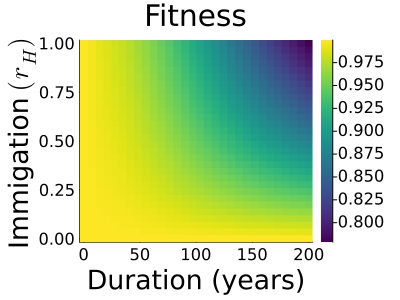

In [80]:
using Plots.PlotMeasures
plot(p1,size = (400,300), right_margin = 10mm)
savefig("figures/Fitness_heatmap.png")
plot(p1,size = (400,300), right_margin = 10mm)

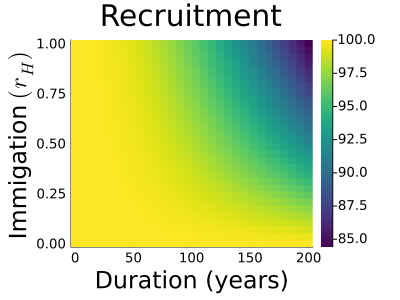

In [81]:
using Plots.PlotMeasures
plot(p2,size = (400,300), right_margin = 10mm)
savefig("figures/abundance_heatmap.png")
plot(p2,size = (400,300), right_margin = 10mm)

# Cumulative data 

In [86]:
using DataFrames
function cumulative_data(popW, popH, rH_vals, cumulatve_vals; N = 10,t_init=50,t_recovery=1000)
    
    N = length(rH_vals)*length(cumulatve_vals)
    rH = zeros(N)
    cumulative = zeros(N)
    T = zeros(N)
    R = zeros(N)
    W = zeros(N)
    g = zeros(N)
    n = 0
    for i in 1:length(rH_vals)
        
        for j in 1:length(cumulatve_vals)
            
            n+=1
            
            t_hatchery = round(Int,cumulatve_vals[j]/rH_vals[i])
            
            data = simulation(popW, popH, rH_vals[i], t_init, t_hatchery, t_recovery)
            
            Wij,Rij,gij=minimum_values(data)
            
            R[n] = Rij;W[n] = Wij;g[n] = gij
            rH[n] = rH_vals[i];cumulative[n]=cumulatve_vals[j]
            T[n] = t_hatchery
                
        end
    end 
    
    return DataFrames.DataFrame(rH = rH, T=T,cumulative=cumulative,Recruitment=R,Fitness=W,mean_genotype=g)
end 
rH_vals = [30,40,50,60.0]
cumulatve_vals = 40.0*collect(25:25.0:200)
cumulative_data_ = cumulative_data(popW, popH, rH_vals, cumulatve_vals)
using CSV
CSV.write("cumulative_data.csv", cumulative_data_)
nothing

In [87]:
groups = []
for i in 1:length(cumulative_data_.rH)
    push!(groups, string(L"r_H = ", cumulative_data_.rH[i]))
end 

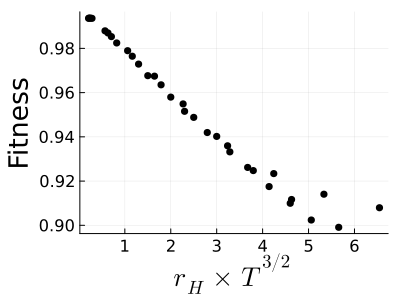

In [89]:
p1 = Plots.scatter(
    0.01*0.005*cumulative_data_.rH.*cumulative_data_.T.^1.5,
    cumulative_data_.Fitness,width = 2.0,color = "black",
    xlabel = L"r_H\times T^{3/2}",ylabel = "Fitness", tickfontsize = 11, 
    guidefontsize = 18, titlefontsize = 20,label ="")

plot(p1,size = (400,300))
savefig("figures/Fitnesss_scatter.png")
plot(p1,size = (400,300))

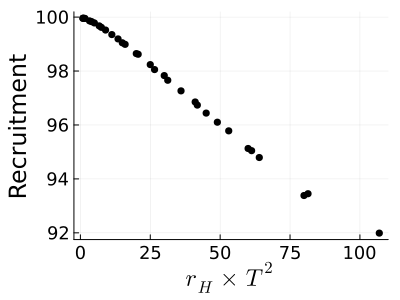

In [90]:
p2 = Plots.scatter(
    0.01*0.005*cumulative_data_.rH.*cumulative_data_.T.^2.0,
    cumulative_data_.Recruitment,color = "black",width = 2.0,
    xlabel = L"r_H\times T^{2}",ylabel = "Recruitment", tickfontsize = 12, 
    guidefontsize = 16, titlefontsize = 20,label ="")
plot(p2,size = (400,300))
savefig("figures/Recruitment_scatter.png")
plot(p2,size = (400,300))

In [35]:
# Accumulation rate 
using DataFrames, GLM

function accumulation_rate(cumulative_data)
    data = DataFrame(X=cumulative_data.rH.*cumulative_data.T.^1.5 , Y= cumulative_data.Fitness)
    ols = lm(@formula(Y ~ X), data)
    slope = GLM.coef(ols)[2]
end 

accumulation_rate (generic function with 1 method)

In [36]:
R0 = 5.0
W100 = 9.3
Wmat = 153^3 *W100/(100^3)
K = 0.034
Linfty = 300
mu_s = 80  
sigma_s = 4 #0 #5
m = 0.04
s1 = 0.25*pars.s
s2 = 0.5*pars.s
s3 = 0.25*pars.s
r = 0.01
rFaplastic = 0.85
include("../src/FecundityAgeRelationships.jl")
function accumulation_rate(popH,R0,r,W100,Wmat,K,Linfty,mu_s,sigma_s,m,s1,s2,s3,rFaplastic;
    Rstar = 100, Vr = 0.5,Amax = 150,rH_vals = [30,45,60],cumulatve_vals = 45.0*collect(25:25:150))

    # init population
    Fa = FecundityAgeRelationships.Walters2006Senescence(Linfty,Wmat,W100,K, 0, mu_s, sigma_s)
    Fa = Fa.(1:Amax)
    Sa = repeat([1-m],Amax) 
    popW = GeneticDemographicModel.init(Sa,Fa,Wa,R0,Rstar,Sd,r,Vr,s1,s2,s3,rFaplastic)
    
    # compute data 
    cumulative_data_ = cumulative_data(popW, popH, rH_vals, cumulatve_vals)
    # slope coeficent
    coef = accumulation_rate(cumulative_data_)
    
    return cumulative_data_ , coef
end 


accumulation_rate (generic function with 2 methods)

In [37]:


dp = 0.01
rH = [20,40,60]
cumulatve = 40 .*[25,50,100,150,200]
dat, coef = accumulation_rate(popH,R0,r,W100,Wmat,K,Linfty,mu_s,sigma_s,m,s1,s2,s3,rFaplastic,
                                    rH_vals = rH,cumulatve_vals = cumulatve)
dat_dR0,coef_dR0 = accumulation_rate(popH,R0+dp,r,W100,Wmat,K,Linfty,mu_s,sigma_s,m,s1,s2,s3,rFaplastic,
                                    rH_vals = rH,cumulatve_vals = cumulatve)
#dat_dr,coef_dr = accumulation_rate(popH,R0,r+dp*r,W100,Wmat,K,Linfty,mu_s,sigma_s,m,s1,s2,s3,rFaplastic)
dat_dW100,coef_dW100 = accumulation_rate(popH,R0,r,W100+dp,Wmat,K,Linfty,mu_s,sigma_s,m,s1,s2,s3,rFaplastic,
                                    rH_vals = rH,cumulatve_vals = cumulatve)
dat_dWmat,coef_dWmat = accumulation_rate(popH,R0,r,W100,Wmat+dp,K,Linfty,mu_s,sigma_s,m,s1,s2,s3,rFaplastic,
                                    rH_vals = rH,cumulatve_vals = cumulatve)
dat_dK,coef_dK = accumulation_rate(popH,R0,r,W100,Wmat,K+dp,Linfty,mu_s,sigma_s,m,s1,s2,s3,rFaplastic,
                                    rH_vals = rH,cumulatve_vals = cumulatve)
dat_dLinfty,coef_dLinfty = accumulation_rate(popH,R0,r,W100,Wmat,K,Linfty+dp,mu_s,sigma_s,m,s1,s2,s3,rFaplastic,
                                    rH_vals = rH,cumulatve_vals = cumulatve)
dat_dmu_s,coef_dmu_s = accumulation_rate(popH,R0,r,W100,Wmat,K,Linfty,mu_s+dp,sigma_s,m,s1,s2,s3,rFaplastic,
                                    rH_vals = rH,cumulatve_vals = cumulatve)
dat_dsigma_s,coef_dsigma_s = accumulation_rate(popH,R0,r,W100,Wmat,K,Linfty,mu_s,sigma_s+dp,m,s1,s2,s3,rFaplastic,
                                    rH_vals = rH,cumulatve_vals = cumulatve)
dat_dm,coef_dm = accumulation_rate(popH,R0,r,W100,Wmat,K,Linfty,mu_s,sigma_s,m+dp,s1,s2,s3,rFaplastic,
                                    rH_vals = rH,cumulatve_vals = cumulatve)
dat_ds1,coef_ds1 = accumulation_rate(popH,R0,r,W100,Wmat,K,Linfty,mu_s,sigma_s,m,s1+dp,s2,s3,rFaplastic,
                                    rH_vals = rH,cumulatve_vals = cumulatve)
dat_ds2,coef_ds2 = accumulation_rate(popH,R0,r,W100,Wmat,K,Linfty,mu_s,sigma_s,m,s1,s2+dp,s3,rFaplastic,
                                    rH_vals = rH,cumulatve_vals = cumulatve)
dat_ds3,coef_ds3 = accumulation_rate(popH,R0,r,W100,Wmat,K,Linfty,mu_s,sigma_s,m,s1,s2,s3+dp,rFaplastic,
                                    rH_vals = rH,cumulatve_vals = cumulatve)
dat_drFaplastic,coef_drFaplastic = accumulation_rate(popH,R0,r,W100,Wmat,K,Linfty,mu_s,sigma_s,m,s1,s2,s3,rFaplastic+dp,
                                    rH_vals = rH,cumulatve_vals = cumulatve)


pars_vals = [R0,W100,Wmat,K,Linfty,mu_s,sigma_s,m,s1,s2,s3,rFaplastic]
vals = [coef_dR0,coef_dW100,coef_dWmat,coef_dK,coef_dLinfty,coef_dmu_s,coef_dsigma_s,coef_dm,coef_ds1,coef_ds2,coef_ds3,coef_drFaplastic]
diffs =  vals.- coef
deltas = pars_vals
CSV.write("derivs.csv", DataFrames.DataFrame(pars = pars_vals,vals = vals,diffs = diffs, deltas = deltas))
    
pars = [R0,W100,Wmat,K,Linfty,mu_s,sigma_s,m,s1,s2,s3,rFaplastic]
vals = [coef_dR0,coef_dW100,coef_dWmat,coef_dK,coef_dLinfty,coef_dmu_s,coef_dsigma_s,coef_dm,
            coef_ds1,coef_ds2,coef_ds3,coef_drFaplastic]
diffs =  (vals .- coef)
deltas = dp
parnames = [L"R_0",L"W_{100}",L"W_{mat}",L"K",L"L_{\infty}",L"\mu_s",L"\sigma_s",L"m",L"s_1",L"s_2",L"s_3",L"rLRS_E"]
derivs =  pars ./ coef .* (diffs ./ deltas)
CSV.write("derivs.csv", DataFrames.DataFrame(pars = pars,vals = vals,diffs = diffs, deltas = deltas,derivs=derivs))
    


"derivs.csv"

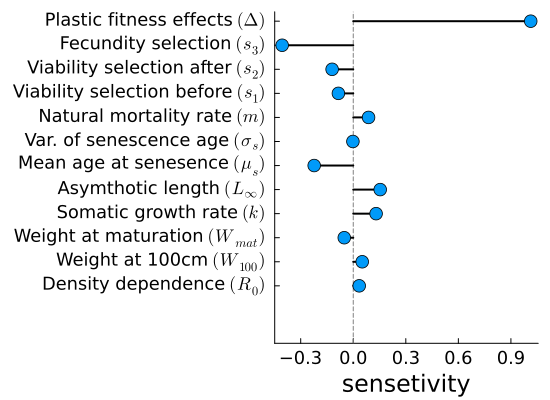

In [44]:
using LaTeXStrings
using CSV
derivs = CSV.read("derivs.csv", DataFrame)
parnames = [string("Density dependence ", L"(R_0)"), 
            string("Weight at 100cm ",L"(W_{100})" ), 
            string("Weight at maturation ",L"(W_{mat})"),
            string("Somatic growth rate ", L"(k)"), 
            string("Asymthotic length ", L"(L_{\infty})"), 
            string("Mean age at senesence ", L"(\mu_s)"),
            string("Var. of senescence age ", L"(\sigma_s)"), 
            string("Natural mortality rate ", L"(m)"), 
            string("Viability selection before ",L"(s_1)"), 
            string("Viability selection after ",L"(s_2)"),
            string("Fecundity selection ",L"(s_3)"),
            string("Plastic fitness effects ",L"(\Delta)")]
derivs = derivs.derivs
p1 = Plots.vline([0.0],label ="", linestyle = :dash, color = "grey")
for i in 1:length(derivs)
    Plots.plot!(p1, [0,derivs[i]],[parnames[i],parnames[i]],color = "black", label = "",linewidth=2)
end

Plots.scatter!(p1,derivs,parnames ,c=1, label = "",ylabel = "",xlabel = "sensetivity",grid=false,
                xguidefontsize=16,yguidefontsize=16,xtickfontsize=12,ytickfontsize=12, markersize = 7)

plot(p1,size = (550,400))
savefig("figures/Sensetivity_analysis.png")
plot(p1,size = (550,400))